<a href="https://colab.research.google.com/github/AftabUdaipurwala/MLProjects/blob/main/Mahindra_Manufacturing_Analytics.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ***Import Python Libraries***

In [1]:
import pandas as pd
import numpy as np
from sklearn import linear_model
from google.colab import drive
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib
matplotlib.rcParams['figure.figsize']=(20,10)
from scipy import stats
import warnings
warnings.filterwarnings("ignore")
import seaborn as sns

from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB,GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV


# ***Mount Google Drive to Load Data***



In [2]:
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
!ls '/content/drive/MyDrive/MahindraManufacturingAnalytics' # listing all the contents in the drive

ManufacturingAnalytics.csv


# ***Load Data***

In [4]:
df = pd.read_csv('/content/drive/MyDrive/MahindraManufacturingAnalytics/ManufacturingAnalytics.csv')
df.head()

,ID,Type,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Machine failure,TWF,HDF,PWF,OSF,RNF
0,1,M,298.1,308.6,1551.0,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2,L,298.2,308.7,1408.0,46.3,3.0,0.0,0.0,0.0,0.0,0.0,0.0
2,3,L,298.1,308.5,1498.0,49.4,5.0,0.0,0.0,0.0,0.0,0.0,0.0
3,4,L,298.2,308.6,1433.0,39.5,7.0,0.0,0.0,0.0,0.0,0.0,0.0
4,5,L,298.2,308.7,1408.0,40.0,9.0,0.0,0.0,0.0,0.0,0.0,0.0


In [5]:
df= pd.DataFrame(df, index = range(0,9999))
df.head()

,ID,Type,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Machine failure,TWF,HDF,PWF,OSF,RNF
0,1,M,298.1,308.6,1551.0,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2,L,298.2,308.7,1408.0,46.3,3.0,0.0,0.0,0.0,0.0,0.0,0.0
2,3,L,298.1,308.5,1498.0,49.4,5.0,0.0,0.0,0.0,0.0,0.0,0.0
3,4,L,298.2,308.6,1433.0,39.5,7.0,0.0,0.0,0.0,0.0,0.0,0.0
4,5,L,298.2,308.7,1408.0,40.0,9.0,0.0,0.0,0.0,0.0,0.0,0.0


# ***Exploratory Data Analysis***

In [6]:
df.shape # checking shape of the data

(9999, 13)

In [7]:
df.describe()
#''' Here we can clearly see that there are lot of outliers in each of thte variable,
# eg just check process temp, its min is 0, max is 11000 but 25th n 75th percentile is very narrow 308-311'''

,ID,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Machine failure,TWF,HDF,PWF,OSF,RNF
count,9999.000000,9984.000000,9986.000000,9991.000000,9995.000000,9993.000000,9995.000000,9995.000000,9995.000000,9995.000000,9995.000000,9995.000000
mean,5000.000000,300.122115,311.046826,1538.054949,41.184282,107.953267,0.033817,0.004602,0.011506,0.009405,0.009805,0.001901
std,2886.607005,17.599673,107.030405,189.139531,120.044630,63.658541,0.180767,0.067687,0.106651,0.096526,0.098538,0.043561
min,1.000000,15.000000,0.000000,-4500.000000,3.800000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2500.500000,298.300000,308.800000,1423.000000,33.200000,53.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,5000.000000,300.100000,310.100000,1503.000000,40.100000,108.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,7499.500000,301.500000,311.100000,1612.000000,46.800000,162.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,9999.000000,2000.000000,11000.000000,2886.000000,12000.000000,253.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [8]:
df.isnull().sum(axis = 0) ## Checking which all columns have null values. Here Couple of points to be noted are 1. the failure type missing values are 4 all togather

ID                          0
Type                        6
Air temperature [K]        15
Process temperature [K]    13
Rotational speed [rpm]      8
Torque [Nm]                 4
Tool wear [min]             6
Machine failure             4
TWF                         4
HDF                         4
PWF                         4
OSF                         4
RNF                         4
dtype: int64

In [9]:
df1=df[df.isnull().any(axis='columns')] # If we take subset of only missing values rows and then investigate
df1.shape

(54, 13)

In [10]:
df1.head(2)

,ID,Type,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Machine failure,TWF,HDF,PWF,OSF,RNF
0,1,M,298.1,308.6,1551.0,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9,10,M,NaN,309.0,1741.0,28.0,21.0,0.0,0.0,0.0,0.0,0.0,0.0


In [11]:
pd.crosstab(df1['Machine failure'],df1['RNF']) 
# So here we can safely say if we remove all these missing values it wont have any big impact on the y variable as only 1 of 50 values is a downtime record. 

RNF,0.0
Machine failure,
0.0,49
1.0,1


In [12]:
pd.crosstab(df['Machine failure'],df['RNF']) # there are 338 incidencies of downtime

RNF,0.0,1.0
Machine failure,,
0.0,9639,18
1.0,337,1


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fccc4e5c1d0>,
      dtype=object)

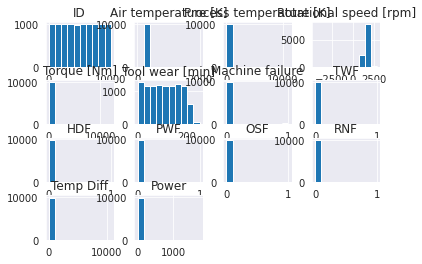

In [116]:
df.hist()

In [14]:
# checking if we have any unique values in each variable or is everything only a single point data?
df2 = df.dropna(axis=0)
df2= df2.drop(['ID'],axis=1)
col_names = df2.columns

for i in col_names:
  x = len(df2[i].unique())
  print('Column Name is',i,'& Count of Unique values is ',x)

Column Name is Type & Count of Unique values is  3
Column Name is Air temperature [K] & Count of Unique values is  95
Column Name is Process temperature [K] & Count of Unique values is  84
Column Name is Rotational speed [rpm] & Count of Unique values is  940
Column Name is Torque [Nm] & Count of Unique values is  577
Column Name is Tool wear [min] & Count of Unique values is  246
Column Name is Machine failure & Count of Unique values is  2
Column Name is TWF & Count of Unique values is  2
Column Name is HDF & Count of Unique values is  2
Column Name is PWF & Count of Unique values is  2
Column Name is OSF & Count of Unique values is  2
Column Name is RNF & Count of Unique values is  2


In [15]:
df2.shape

(9945, 12)

In [16]:
# creating a function to check values between 2 quantiles

def check_range(df, col):
  q_low = df[col].quantile(0.25)
  q_hi  = df[col].quantile(0.75)    
  print(col,"qhi",q_hi,'qlow',q_low)


In [17]:
df3 = df2.drop(['Type','Machine failure', 'TWF', 'HDF', 'PWF', 'OSF', 'RNF'], axis=1)
col_names=df3.columns
col_names

for i in col_names:
  check_range(df3,i)

Air temperature [K] qhi 301.5 qlow 298.4
Process temperature [K] qhi 311.1 qlow 308.8
Rotational speed [rpm] qhi 1612.0 qlow 1423.0
Torque [Nm] qhi 46.8 qlow 33.2
Tool wear [min] qhi 162.0 qlow 53.0


In [18]:
# creating a function to check values between 2 quantiles

def drop_numerical_outliers(df, col):
  q_low = df[col].quantile(0.01)
  q_hi  = df[col].quantile(0.99)    
  df= df[(df[col] < q_hi) & (df[col] > q_low)]
  return df


In [19]:
df4= df2.copy()
df4 = drop_numerical_outliers(df4,'Air temperature [K]')
df4 = drop_numerical_outliers(df4,'Process temperature [K]')
df4 = drop_numerical_outliers(df4,'Rotational speed [rpm]')
df4 = drop_numerical_outliers(df4,'Torque [Nm]')
df4 = drop_numerical_outliers(df4,'Tool wear [min]')

In [20]:
df4.shape

(8891, 12)

In [21]:
df4.head()

,Type,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Machine failure,TWF,HDF,PWF,OSF,RNF
1,L,298.2,308.7,1408.0,46.3,3.0,0.0,0.0,0.0,0.0,0.0,0.0
2,L,298.1,308.5,1498.0,49.4,5.0,0.0,0.0,0.0,0.0,0.0,0.0
3,L,298.2,308.6,1433.0,39.5,7.0,0.0,0.0,0.0,0.0,0.0,0.0
4,L,298.2,308.7,1408.0,40.0,9.0,0.0,0.0,0.0,0.0,0.0,0.0
5,M,298.1,308.6,1425.0,41.9,11.0,0.0,0.0,0.0,0.0,0.0,0.0


In [22]:
df4.describe()

,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Machine failure,TWF,HDF,PWF,OSF,RNF
count,8891.000000,8891.000000,8891.000000,8891.000000,8891.000000,8891.000000,8891.000000,8891.000000,8891.000000,8891.000000,8891.000000
mean,299.989248,309.998763,1528.674840,40.029277,108.422225,0.021820,0.003262,0.010797,0.001012,0.006299,0.002137
std,1.847364,1.332128,141.770453,8.948229,61.988080,0.146103,0.057022,0.103354,0.031802,0.079117,0.046181
min,296.300000,307.400000,1276.000000,19.700000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,298.400000,308.900000,1426.000000,33.500000,55.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,300.100000,310.100000,1503.000000,40.100000,108.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,301.400000,311.000000,1606.000000,46.500000,162.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,304.000000,312.900000,2103.000000,61.900000,222.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [23]:
df5=df4[df4.isnull().any(axis='columns')] # If we take subset of only missing values rows and then investigate
df5.shape

(0, 12)

In [24]:
pd.crosstab(df2['Machine failure'],df2['RNF'])   # Here we can see that if we try to remove outliers a lot of downtime data is lost

RNF,0.0,1.0
Machine failure,,
0.0,9590,18
1.0,336,1


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fccdaf51dd0>,
      dtype=object)

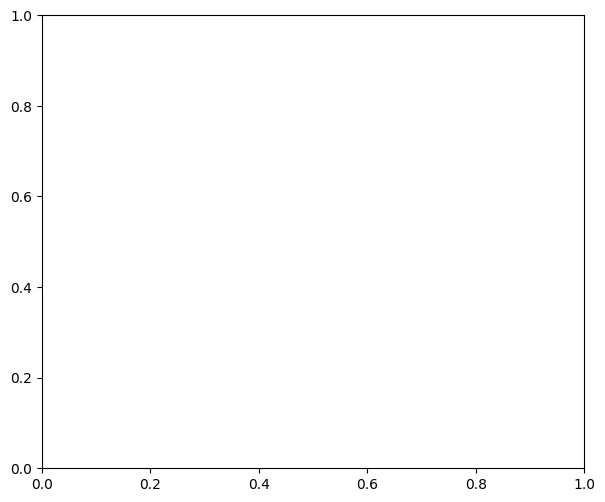

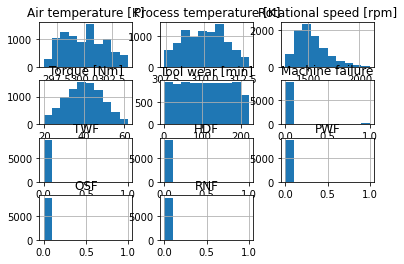

In [25]:
plt.subplots(figsize=(7,6), dpi=100)
df4.hist()

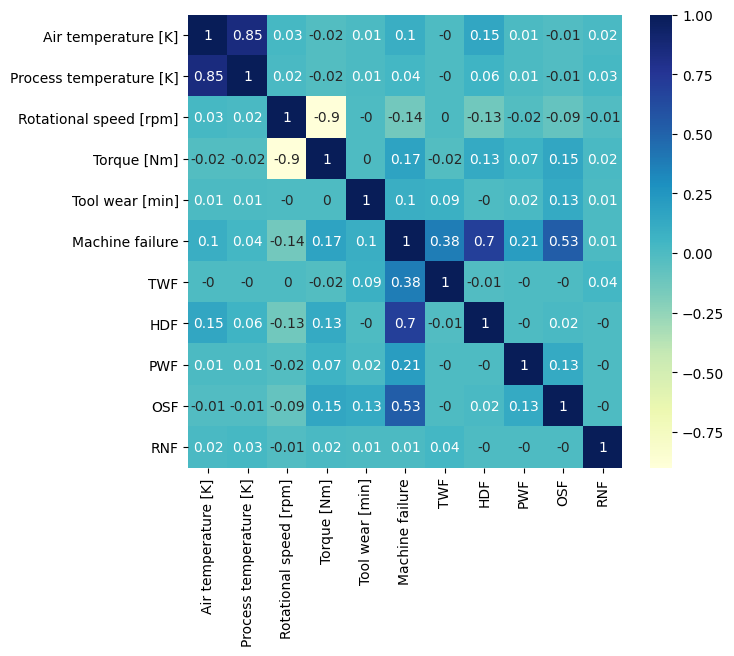

In [26]:
import seaborn as sns
plt.subplots(figsize=(7,6), dpi=100)
dataplot = sns.heatmap(round(df4.corr(method ='pearson'),2), cmap="YlGnBu", annot=True) # Also we can clearly say RPM & Torque as we know by Engg has high correlation , also same with air temp & prcess temp
# Can we use Air Temp & Process temp difference

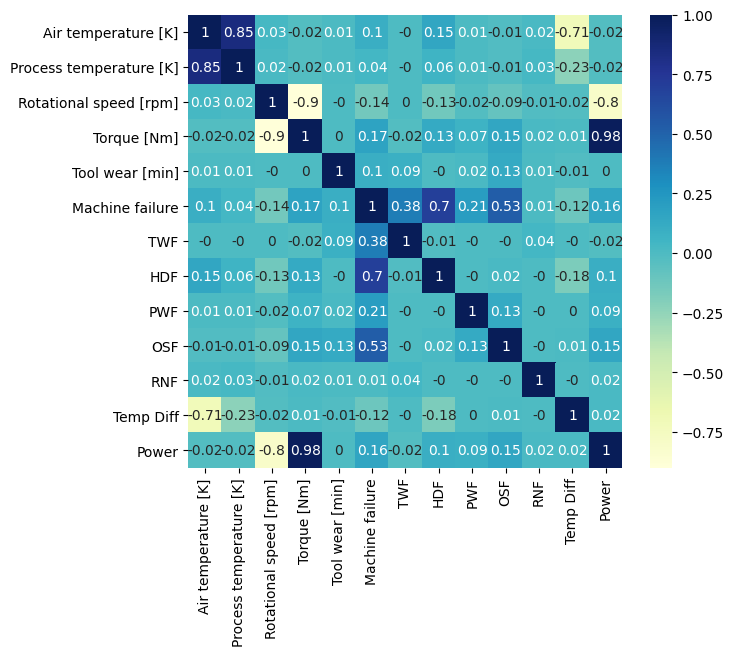

In [27]:
df4['Temp Diff'] = (abs(df4['Air temperature [K]']-df4['Process temperature [K]']))
df4['Power'] = df4['Torque [Nm]']*df4['Rotational speed [rpm]']/9.548/1000
plt.subplots(figsize=(7,6), dpi=100)
dataplot = sns.heatmap(round(df4.corr(method ='pearson'),2), cmap="YlGnBu", annot=True) # Also we can clearly say RPM & Torque as we know by Engg has high correlation , also same with air temp & prcess temp
# Can we use Air Temp & Process temp difference

In [28]:
col_names= list(df4.columns)
col_names.remove('Type')
col_names.remove('Air temperature [K]')
col_names.remove('Process temperature [K]')
col_names.remove('Rotational speed [rpm]')
col_names.remove('Torque [Nm]')
col_names.remove('TWF')
col_names.remove('HDF')
col_names.remove('PWF')
col_names.remove('OSF')
col_names.remove('RNF')
col_names.remove('Machine failure')



col_names

['Tool wear [min]', 'Temp Diff', 'Power']

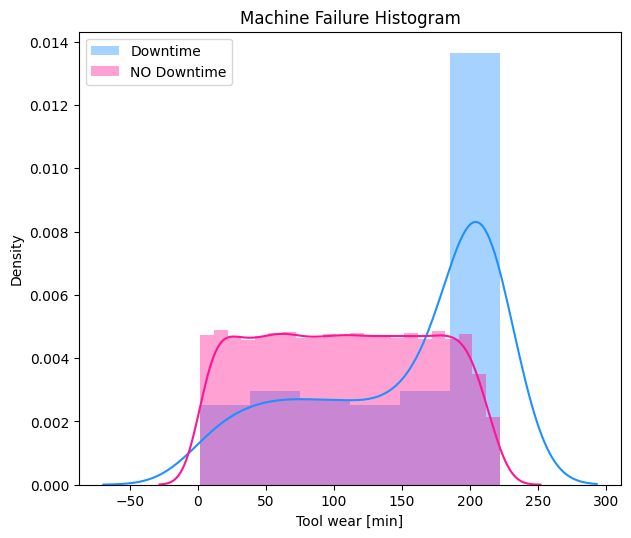

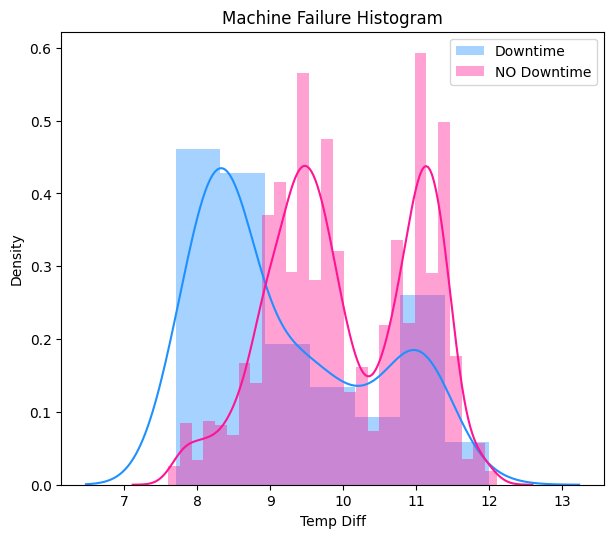

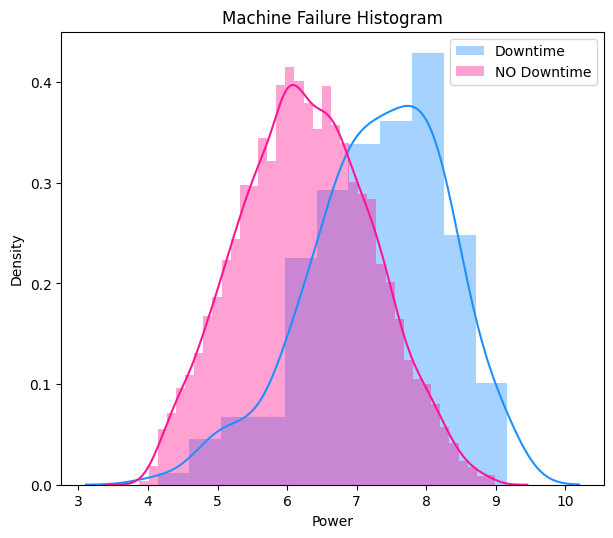

In [29]:

for i in col_names:

    plt.subplots(figsize=(7,6), dpi=100)
    sns.distplot( df4.loc[df4['Machine failure']==1, i] , color="dodgerblue", label="Downtime")
    sns.distplot( df4.loc[df4['Machine failure']==0, i] , color="deeppink", label="NO Downtime")
    plt.title('Machine Failure Histogram')
    plt.legend();




# ***Data Cleaning & New Features Creation***

In [30]:
# Instead of removing outliers just replacing the values with 99th and 1st percentile values

df['Temp Diff'] = (abs(df['Air temperature [K]']-df['Process temperature [K]']))
df['Power'] = df['Torque [Nm]']*df['Rotational speed [rpm]']/9.548/1000

df5 = df[['Type','Tool wear [min]',  'Temp Diff', 'Power','Machine failure','TWF','OSF','RNF','HDF','PWF']]
df5.head(6)


,Type,Tool wear [min],Temp Diff,Power,Machine failure,TWF,OSF,RNF,HDF,PWF
0,M,0.0,10.5,NaN,0.0,0.0,0.0,0.0,0.0,0.0
1,L,3.0,10.5,6.827650,0.0,0.0,0.0,0.0,0.0,0.0
2,L,5.0,10.4,7.750440,0.0,0.0,0.0,0.0,0.0,0.0
3,L,7.0,10.4,5.928310,0.0,0.0,0.0,0.0,0.0,0.0
4,L,9.0,10.5,5.898618,0.0,0.0,0.0,0.0,0.0,0.0
5,M,11.0,10.5,6.253404,0.0,0.0,0.0,0.0,0.0,0.0


In [31]:
df5.shape

(9999, 10)

In [32]:
df5['Power']=df5['Power'].clip(lower=df5['Power'].quantile(0.01), upper=df5['Power'].quantile(0.99))
df5['Tool wear [min]']=df5['Tool wear [min]'].clip(lower=df5['Tool wear [min]'].quantile(0.01), upper=df5['Tool wear [min]'].quantile(0.99))
df5['Temp Diff']=df5['Temp Diff'].clip(lower=df5['Temp Diff'].quantile(0.01), upper=df5['Temp Diff'].quantile(0.99))


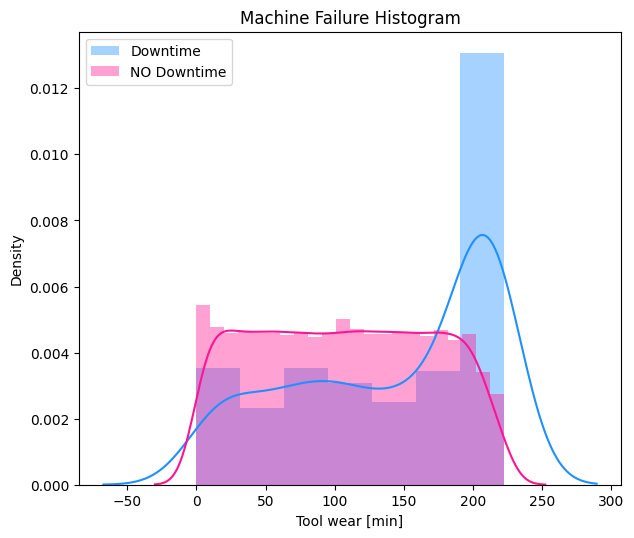

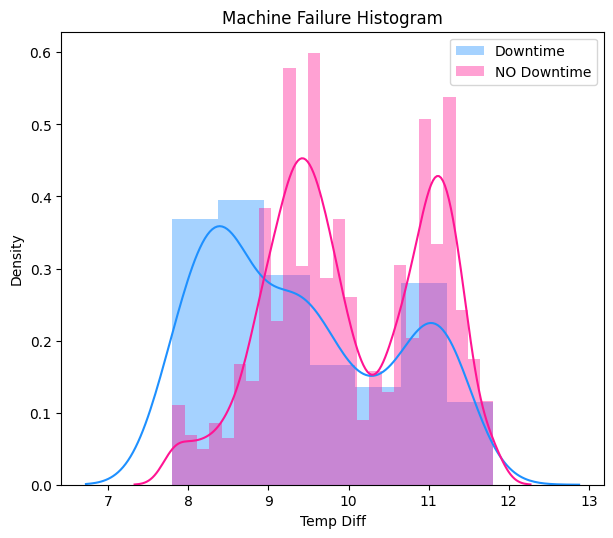

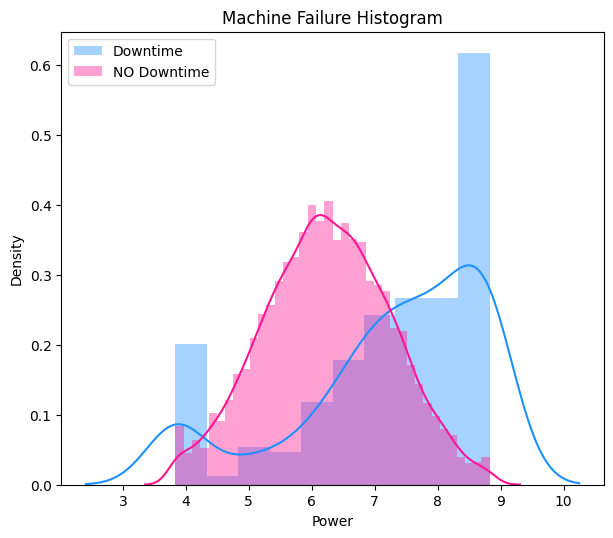

In [33]:

for i in col_names:

    plt.subplots(figsize=(7,6), dpi=100)
    sns.distplot( df5.loc[df5['Machine failure']==1, i] , color="dodgerblue", label="Downtime")
    sns.distplot( df5.loc[df5['Machine failure']==0, i] , color="deeppink", label="NO Downtime")
    plt.title('Machine Failure Histogram')
    plt.legend();




# ***Data Preparation for Model Building***

In [34]:
df5 = df5.dropna(axis=0)
df5.shape
df7=df5.copy()

In [35]:
pd.crosstab(df5['Machine failure'],df5['RNF']) 

RNF,0.0,1.0
Machine failure,,
0.0,9590,18
1.0,336,1


In [36]:
from sklearn.model_selection import train_test_split
x=df5.drop(['Machine failure','TWF','OSF','RNF','HDF','PWF'], axis=1)
y=df5['Machine failure']

x= pd.get_dummies(x)
x= x.drop(['Type_L'], axis=1)

xtrain, xtest, ytrain, ytest = train_test_split(x, y,
                                                    stratify=y, 
                                                    test_size=0.25,
                                                    random_state=123)

In [37]:
print(len(xtrain),len(xtest))

7458 2487


In [38]:
xtest.head(4)

,Tool wear [min],Temp Diff,Power,Type_H,Type_M
1330,214.0,11.3,5.364390,0,0
7572,158.0,10.8,5.020276,0,0
1359,54.0,11.5,7.396439,0,0
3953,22.0,9.1,6.139296,0,1


# ***Trying Base Model as Logistic Regression***

In [39]:
from sklearn.linear_model import LogisticRegression
model = LogisticRegression(solver='saga')
model.fit(xtrain,ytrain)
model.score(xtrain,ytrain)

0.9660766961651918

In [40]:
model.score(xtest,ytest)

0.9662243667068757

In [41]:
model.predict_proba(xtest)

array([[0.98516198, 0.01483802],
       [0.98840102, 0.01159898],
       [0.99190517, 0.00809483],
       ...,
       [0.93597498, 0.06402502],
       [0.93248584, 0.06751416],
       [0.99471243, 0.00528757]])

In [42]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

ypred=model.predict(xtest)
from sklearn.metrics import confusion_matrix
cm= confusion_matrix(ytest,ypred)
cm



# classification report for precision, recall f1-score and accuracy
matrix = classification_report(ytest,ypred,labels=[1,0])
print('Classification report : \n',matrix)

Classification report : 
               precision    recall  f1-score   support

           1       0.00      0.00      0.00        84
           0       0.97      1.00      0.98      2403

    accuracy                           0.97      2487
   macro avg       0.48      0.50      0.49      2487
weighted avg       0.93      0.97      0.95      2487



Text(69.0, 0.5, 'Truth')

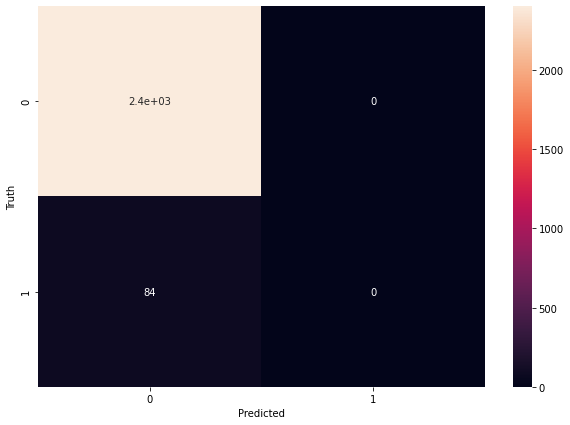

In [43]:
# visualizing the confusion matrix using Seaborn library in python
import seaborn as sn
plt.figure(figsize=(10,7))
sn.heatmap(cm, annot=True)
plt.xlabel('Predicted')
plt.ylabel('Truth') # just look at the confusion matrix not even a single downtime is predicted

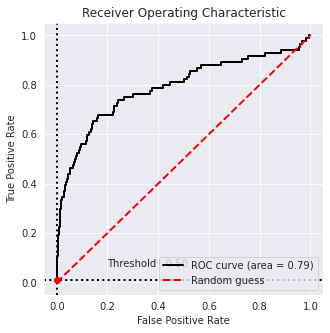

In [44]:
ypred = model.predict_proba(xtest)[::,1]
!pip install plot_metric
from plot_metric.functions import BinaryClassification
# Visualisation with plot_metric
bc = BinaryClassification(ytest, ypred, labels=["Class 1", "Class 2"])

# Figures
plt.figure(figsize=(5,5))
bc.plot_roc_curve()
plt.show()
# Although the ROC curve is 81% but look at threshold, its 0,0 so it means this model doesnt work


# ***Trying all models togather***

In [ ]:
# now finding out the best model
# trying all models with Default parameters 


model_params = {
    'svm':{
        'model':SVC(gamma='auto'),
        'params':{
            'C': [1,10,20],
            'kernel':['rbf','linear']
        }
    },
    'RandomForest':{
        'model':RandomForestClassifier(),
        'params':{
            'n_estimators':[1,5,10]
        }
    },
        'LogisticRegresson':{
        'model':LogisticRegression(solver='saga',multi_class='auto'),
        'params':{
            'C':[1,5,10]
        }
    }
}

In [ ]:
scores =[]
for model_name,mp in model_params.items():
  clf= GridSearchCV(mp['model'],mp['params'],cv=5,return_train_score=False)
  clf.fit(x,y)
  scores.append({
      'model':model_name,
      'best_score':clf.best_score_,
      'best_params':clf.best_params_
  })
pd.DataFrame(scores)

,model,best_score,best_params
0,svm,0.966616,"{'C': 1, 'kernel': 'rbf'}"
1,RandomForest,0.928406,{'n_estimators': 10}
2,LogisticRegresson,0.966315,{'C': 1}


In [ ]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score

d = pd.DataFrame()
d

""


In [ ]:
'''
Cost =np.arange(1,5,1)
Gamma = np.arange(1,2,0.1)
kernel = ['rbf','linear','sigmoid','poly']



for i in kernel:
  for j in Gamma:
    for k in Cost:
      model = SVC(kernel=i,
                  gamma=j,
                  C=k)
      model.fit(xtrain,ytrain)
      ypred=model.predict(xtest)
      Acc= model.score(xtest,ytest)
      d= d.append([[i,j,k,Acc]])
      '''

"\nCost =np.arange(1,5,1)\nGamma = np.arange(1,2,0.1)\nkernel = ['rbf','linear','sigmoid','poly']\n\n\n\nfor i in kernel:\n  for j in Gamma:\n    for k in Cost:\n      model = SVC(kernel=i,\n                  gamma=j,\n                  C=k)\n      model.fit(xtrain,ytrain)\n      ypred=model.predict(xtest)\n      Acc= model.score(xtest,ytest)\n      d= d.append([[i,j,k,Acc]])\n      "

In [ ]:
'''columns = ['Kernel','Gamma','Cost','Accuracy']
d.columns = columns'''

"columns = ['Kernel','Gamma','Cost','Accuracy']\nd.columns = columns"

In [ ]:
#d

In [ ]:
#maxValueIndex = d['Accuracy'].max()
#maxValueIndex

In [ ]:
#model.score(xtest,ytest)

In [ ]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

ypred=model.predict(xtest)
from sklearn.metrics import confusion_matrix
cm= confusion_matrix(ytest,ypred)
cm

# classification report for precision, recall f1-score and accuracy
matrix = classification_report(ytest,ypred,labels=[1,0])
print('Classification report : \n',matrix)

Classification report : 
               precision    recall  f1-score   support

           1       0.00      0.00      0.00        84
           0       0.97      1.00      0.98      2403

    accuracy                           0.97      2487
   macro avg       0.48      0.50      0.49      2487
weighted avg       0.93      0.97      0.95      2487



Text(69.0, 0.5, 'Truth')

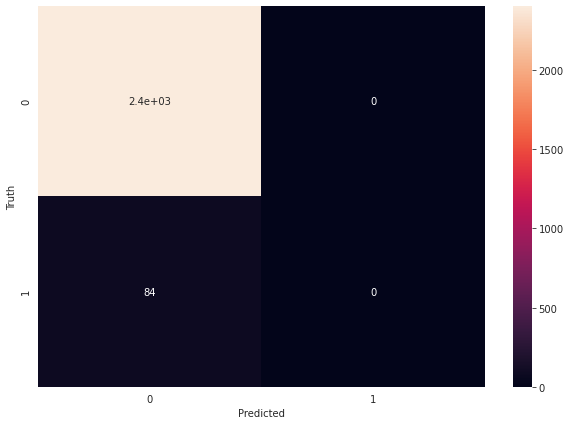

In [ ]:
# visualizing the confusion matrix using Seaborn library in python
import seaborn as sn
plt.figure(figsize=(10,7))
sn.heatmap(cm, annot=True)
plt.xlabel('Predicted')
plt.ylabel('Truth') # just look at the confusion matrix not even a single downtime is predicted

# ***Trying with Original Dataset***

In [45]:
df5 = df.dropna(axis=0)
df5.shape

(9945, 15)

In [46]:
pd.crosstab(df5['Machine failure'],df5['RNF']) 

RNF,0.0,1.0
Machine failure,,
0.0,9590,18
1.0,336,1


In [47]:
df5.head()

,ID,Type,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Machine failure,TWF,HDF,PWF,OSF,RNF,Temp Diff,Power
1,2,L,298.2,308.7,1408.0,46.3,3.0,0.0,0.0,0.0,0.0,0.0,0.0,10.5,6.827650
2,3,L,298.1,308.5,1498.0,49.4,5.0,0.0,0.0,0.0,0.0,0.0,0.0,10.4,7.750440
3,4,L,298.2,308.6,1433.0,39.5,7.0,0.0,0.0,0.0,0.0,0.0,0.0,10.4,5.928310
4,5,L,298.2,308.7,1408.0,40.0,9.0,0.0,0.0,0.0,0.0,0.0,0.0,10.5,5.898618
5,6,M,298.1,308.6,1425.0,41.9,11.0,0.0,0.0,0.0,0.0,0.0,0.0,10.5,6.253404


In [48]:
from sklearn.model_selection import train_test_split
x=df5.drop(['Machine failure','TWF','OSF','RNF','HDF','PWF'], axis=1)
y=df5['Machine failure']

x= pd.get_dummies(x)
x= x.drop(['Type_L'], axis=1)

xtrain, xtest, ytrain, ytest = train_test_split(x, y,
                                                    stratify=y, 
                                                    test_size=0.25,
                                                    random_state=123)

In [49]:
from sklearn.linear_model import LogisticRegression
model = LogisticRegression(solver='saga')
model.fit(xtrain,ytrain)
model.score(xtrain,ytrain)

0.9660766961651918

In [50]:
model.score(xtest,ytest)

0.9658222758343386

In [51]:
model.predict_proba(xtest)

array([[0.95771858, 0.04228142],
       [0.97481782, 0.02518218],
       [0.96266469, 0.03733531],
       ...,
       [0.97755541, 0.02244459],
       [0.96416251, 0.03583749],
       [0.9836037 , 0.0163963 ]])

In [52]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

ypred=model.predict(xtest)
from sklearn.metrics import confusion_matrix
cm= confusion_matrix(ytest,ypred)
cm



# classification report for precision, recall f1-score and accuracy
matrix = classification_report(ytest,ypred,labels=[1,0])
print('Classification report : \n',matrix)

Classification report : 
               precision    recall  f1-score   support

           1       0.00      0.00      0.00        84
           0       0.97      1.00      0.98      2403

    accuracy                           0.97      2487
   macro avg       0.48      0.50      0.49      2487
weighted avg       0.93      0.97      0.95      2487



Text(69.0, 0.5, 'Truth')

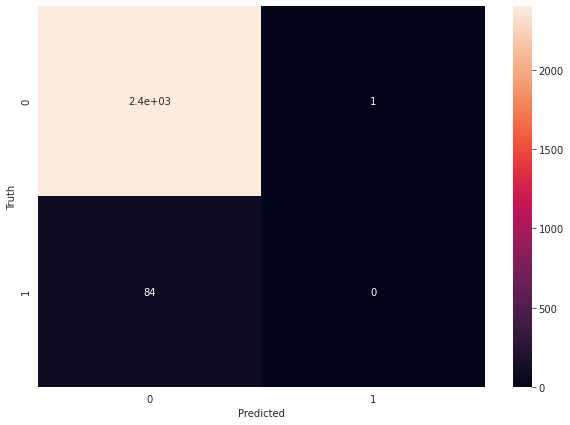

In [53]:
# visualizing the confusion matrix using Seaborn library in python
import seaborn as sn
plt.figure(figsize=(10,7))
sn.heatmap(cm, annot=True)
plt.xlabel('Predicted')
plt.ylabel('Truth') # just look at the confusion matrix not even a single downtime is predicted

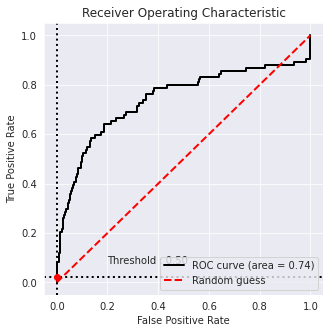

In [54]:
ypred = model.predict_proba(xtest)[::,1]
!pip install plot_metric
from plot_metric.functions import BinaryClassification
# Visualisation with plot_metric
bc = BinaryClassification(ytest, ypred, labels=["Class 1", "Class 2"])

# Figures
plt.figure(figsize=(5,5))
bc.plot_roc_curve()
plt.show()
# Although the ROC curve is 81% but look at threshold, its 0,0 so it means this model doesnt work



# ***Decision Tree with SMOTE***

In [55]:
df7.head()

,Type,Tool wear [min],Temp Diff,Power,Machine failure,TWF,OSF,RNF,HDF,PWF
1,L,3.0,10.5,6.827650,0.0,0.0,0.0,0.0,0.0,0.0
2,L,5.0,10.4,7.750440,0.0,0.0,0.0,0.0,0.0,0.0
3,L,7.0,10.4,5.928310,0.0,0.0,0.0,0.0,0.0,0.0
4,L,9.0,10.5,5.898618,0.0,0.0,0.0,0.0,0.0,0.0
5,M,11.0,10.5,6.253404,0.0,0.0,0.0,0.0,0.0,0.0


In [56]:
df7.shape

(9945, 10)

In [57]:
!pip install imbalanced-learn
# check version number
import imblearn
print(imblearn.__version__)

0.4.3


In [58]:
from sklearn.model_selection import train_test_split
x=df7.drop(['Machine failure','TWF','OSF','RNF','HDF','PWF'], axis=1)
y=df7['Machine failure']

x= pd.get_dummies(x)
x= x.drop(['Type_L'], axis=1)


In [59]:
from collections import Counter
counter = Counter(y)
print(counter)


Counter({0.0: 9608, 1.0: 337})


In [60]:
from collections import Counter
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline
from matplotlib import pyplot
from numpy import where
over = SMOTE(sampling_strategy=0.1)
under = RandomUnderSampler(sampling_strategy=0.5)

In [61]:
steps = [('o', over), ('u', under)]
pipeline = Pipeline(steps=steps)

In [62]:
# transform the dataset
from sklearn.model_selection import train_test_split
x=df7.drop(['Machine failure','TWF','OSF','RNF','HDF','PWF'], axis=1)
y=df7['Machine failure']

x= pd.get_dummies(x)
x= x.drop(['Type_L'], axis=1)
x, y = pipeline.fit_resample(x, y)
xtrain, xtest, ytrain, ytest = train_test_split(x, y,
                                                    stratify=y, 
                                                    test_size=0.25,
                                                    random_state=123)

In [63]:
counter = Counter(y)
print(counter)

Counter({0.0: 1920, 1.0: 960})


In [64]:
from numpy import mean
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.tree import DecisionTreeClassifier

In [65]:
# define model
model = DecisionTreeClassifier()
# evaluate pipeline
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
scores = cross_val_score(model, x, y, scoring='precision', cv=cv, n_jobs=-1)
print('Mean Precision: %.3f' % mean(scores))

Mean Precision: 0.833


In [66]:
model.fit(xtrain,ytrain)
model.score(xtest,ytest)

0.8930555555555556

In [67]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

ypred=model.predict(xtest)
from sklearn.metrics import confusion_matrix
cm= confusion_matrix(ytest,ypred)
cm

# classification report for precision, recall f1-score and accuracy
matrix = classification_report(ytest,ypred,labels=[1,0])
print('Classification report : \n',matrix)

Classification report : 
               precision    recall  f1-score   support

           1       0.86      0.81      0.84       240
           0       0.91      0.93      0.92       480

    accuracy                           0.89       720
   macro avg       0.88      0.87      0.88       720
weighted avg       0.89      0.89      0.89       720



Text(69.0, 0.5, 'Truth')

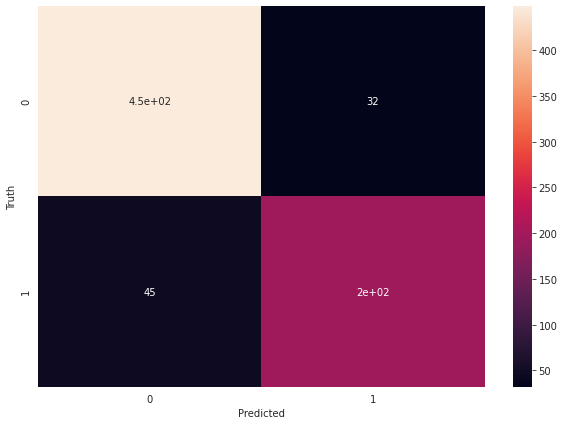

In [68]:
# visualizing the confusion matrix using Seaborn library in python
import seaborn as sn
plt.figure(figsize=(10,7))
sn.heatmap(cm, annot=True)
plt.xlabel('Predicted')
plt.ylabel('Truth') # just look at the confusion matrix not even a single downtime is predicted

In [69]:
cm

array([[448,  32],
       [ 45, 195]])

In [70]:
# On overall Dataset
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

ypred=model.predict(x)
from sklearn.metrics import confusion_matrix
cm= confusion_matrix(y,ypred)
cm

array([[1888,   32],
       [  45,  915]])

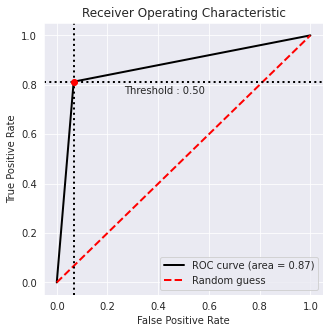

In [71]:
ypred = model.predict_proba(xtest)[::,1]
!pip install plot_metric
from plot_metric.functions import BinaryClassification
# Visualisation with plot_metric
bc = BinaryClassification(ytest, ypred, labels=["Class 1", "Class 2"])

# Figures
plt.figure(figsize=(5,5))
bc.plot_roc_curve()
plt.show()

# Now the ROC value is also improved


# ***XGBooost***

In [72]:
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# fit model no training data
model = XGBClassifier()
model.fit(xtrain, ytrain)
# evaluate pipeline
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
scores = cross_val_score(model, x, y, scoring='precision', cv=cv, n_jobs=-1)
print('Mean Precision: %.3f' % mean(scores))

Mean Precision: 0.872


In [73]:
model.fit(xtrain,ytrain)
model.score(xtest,ytest)

0.9111111111111111

In [74]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

ypred=model.predict(xtest)
from sklearn.metrics import confusion_matrix
cm= confusion_matrix(ytest,ypred)
cm

# classification report for precision, recall f1-score and accuracy
matrix = classification_report(ytest,ypred,labels=[1,0])
print('Classification report : \n',matrix)

Classification report : 
               precision    recall  f1-score   support

           1       0.89      0.84      0.86       240
           0       0.92      0.95      0.93       480

    accuracy                           0.91       720
   macro avg       0.91      0.89      0.90       720
weighted avg       0.91      0.91      0.91       720



Text(69.0, 0.5, 'Truth')

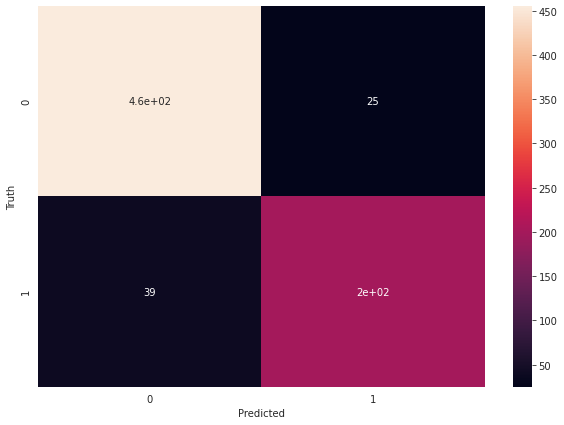

In [75]:
# visualizing the confusion matrix using Seaborn library in python
import seaborn as sn
plt.figure(figsize=(10,7))
sn.heatmap(cm, annot=True)
plt.xlabel('Predicted')
plt.ylabel('Truth') # just look at the confusion matrix not even a single downtime is predicted

In [76]:
cm

array([[455,  25],
       [ 39, 201]])

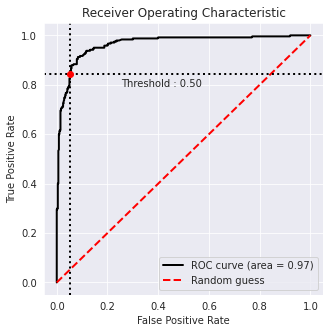

In [77]:
ypred = model.predict_proba(xtest)[::,1]
!pip install plot_metric
from plot_metric.functions import BinaryClassification
# Visualisation with plot_metric
bc = BinaryClassification(ytest, ypred, labels=["Class 1", "Class 2"])

# Figures
plt.figure(figsize=(5,5))
bc.plot_roc_curve()
plt.show()

# Now the ROC value is also improved


# ***Identifying the Optimal Threshold Levels***

In [113]:
df8= df5.copy()
df8.shape

(9945, 15)

In [125]:
# Creating the bins of each of the 3 variable that is Power, Temperature Difference and Tool Wear Mins


bins = [2,3,4,5,6,7,8,9,10,11,12]
labels = [f'{int(i)}-{int(j)}' for i, j in zip(bins[:-1], bins[1:])] 

df8['Power bin'] = pd.cut(df8.Power, bins=bins, labels=labels, right=False)


bins = [6,7,8,9,10,11,12,13,14]
labels = [f'{int(i)}-{int(j)}' for i, j in zip(bins[:-1], bins[1:])] 

df8['Temp Diff bin'] = pd.cut(df8['Temp Diff'], bins=bins, labels=labels, right=False)

bins = [0,50,100,150,200,250,300]
labels = [f'{int(i)}-{int(j)}' for i, j in zip(bins[:-1], bins[1:])] 

df8['Tool Wear Bin'] = pd.cut(df8['Tool wear [min]'], bins=bins, labels=labels, right=False)
df8.head(20)


,ID,Type,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Machine failure,TWF,HDF,PWF,OSF,RNF,Temp Diff,Power,Power bin,Temp Diff bin,Tool Wear Bin
1,2,L,298.2,308.7,1408.0,46.3,3.0,0.0,0.0,0.0,0.0,0.0,0.0,10.5,6.827650,6-7,10-11,0-50
2,3,L,298.1,308.5,1498.0,49.4,5.0,0.0,0.0,0.0,0.0,0.0,0.0,10.4,7.750440,7-8,10-11,0-50
3,4,L,298.2,308.6,1433.0,39.5,7.0,0.0,0.0,0.0,0.0,0.0,0.0,10.4,5.928310,5-6,10-11,0-50
4,5,L,298.2,308.7,1408.0,40.0,9.0,0.0,0.0,0.0,0.0,0.0,0.0,10.5,5.898618,5-6,10-11,0-50
5,6,M,298.1,308.6,1425.0,41.9,11.0,0.0,0.0,0.0,0.0,0.0,0.0,10.5,6.253404,6-7,10-11,0-50
6,7,L,298.1,308.6,1558.0,42.4,14.0,0.0,0.0,0.0,0.0,0.0,0.0,10.5,6.918643,6-7,10-11,0-50
7,8,L,298.1,308.6,1527.0,40.2,16.0,0.0,0.0,0.0,0.0,0.0,0.0,10.5,6.429137,6-7,10-11,0-50
8,9,M,298.3,308.7,1667.0,28.6,18.0,0.0,0.0,0.0,0.0,0.0,0.0,10.4,4.993318,4-5,10-11,0-50
16,17,M,298.6,309.2,1311.0,46.6,44.0,0.0,0.0,0.0,0.0,0.0,0.0,10.6,6.398471,6-7,10-11,0-50
17,18,M,298.7,309.2,1410.0,45.6,47.0,0.0,0.0,0.0,0.0,0.0,0.0,10.5,6.733976,6-7,10-11,0-50


In [132]:
# now identifying how much of downtime is present in each bins of tool wear
pivottool1=pd.pivot_table(data=df8, index='Tool Wear Bin', values='Type', aggfunc='count').reset_index().rename(columns={'Type': 'Total Data Points'}).round(1)
pivottool2 =pd.pivot_table(data=df8, index='Tool Wear Bin', values='Machine failure', aggfunc='sum').reset_index().rename(columns={'Type': 'Machine Failure Data Points'}).round(1)
pivottool3= pd.merge(pivottool1,pivottool2,on='Tool Wear Bin')
pivottool3['Failure%age'] = round(pivottool3['Machine failure']/pivottool3['Total Data Points'],2)*100
pivottool3

,Tool Wear Bin,Total Data Points,Machine failure,Failure%age
0,0-50,2331,51.0,2.0
1,50-100,2261,51.0,2.0
2,100-150,2283,52.0,2.0
3,150-200,2279,60.0,3.0
4,200-250,789,121.0,15.0
5,250-300,2,2.0,100.0


In [130]:
# now identifying how much % age of downtime is present in each bins of Temp Diff
pivottool1=pd.pivot_table(data=df8, index='Temp Diff bin', values='Type', aggfunc='count').reset_index().rename(columns={'Type': 'Total Data Points'}).round(1)
pivottool2 =pd.pivot_table(data=df8, index='Temp Diff bin', values='Machine failure', aggfunc='sum').reset_index().rename(columns={'Type': 'Machine Failure Data Points'}).round(1)
pivottool3= pd.merge(pivottool1,pivottool2,on='Temp Diff bin')
pivottool3['Failure%age'] = round(pivottool3['Machine failure']/pivottool3['Total Data Points'],2)*100
pivottool3

,Temp Diff bin,Total Data Points,Machine failure,Failure%age
0,6-7,0,0.0,NaN
1,7-8,194,30.0,15.0
2,8-9,1241,117.0,9.0
3,9-10,3894,85.0,2.0
4,10-11,2075,52.0,3.0
5,11-12,2506,52.0,2.0
6,12-13,31,1.0,3.0
7,13-14,0,0.0,NaN


In [131]:
# now identifying how much % age of downtime is present in each bins of Temp Diff
pivottool1=pd.pivot_table(data=df8, index='Power bin', values='Type', aggfunc='count').reset_index().rename(columns={'Type': 'Total Data Points'}).round(1)
pivottool2 =pd.pivot_table(data=df8, index='Power bin', values='Machine failure', aggfunc='sum').reset_index().rename(columns={'Type': 'Machine Failure Data Points'}).round(1)
pivottool3= pd.merge(pivottool1,pivottool2,on='Power bin')
pivottool3['Failure%age'] = round(pivottool3['Machine failure']/pivottool3['Total Data Points'],2)*100
pivottool3

,Power bin,Total Data Points,Machine failure,Failure%age
0,2-3,6,6.0,100.0
1,3-4,140,21.0,15.0
2,4-5,973,8.0,1.0
3,5-6,2811,19.0,1.0
4,6-7,3508,57.0,2.0
5,7-8,1953,90.0,5.0
6,8-9,485,69.0,14.0
7,9-10,57,57.0,100.0
8,10-11,5,5.0,100.0
9,11-12,0,0.0,NaN


# ***Root Cause Identification***

In [79]:
df9= df5.copy()

In [80]:
df9= df9[df9['Machine failure']==1] # removing RNF as its not important
df9.shape

(337, 15)

In [81]:
df9.head()

,ID,Type,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Machine failure,TWF,HDF,PWF,OSF,RNF,Temp Diff,Power
50,51,L,298.9,309.1,2861.0,4.6,143.0,1.0,0.0,0.0,1.0,0.0,0.0,10.2,1.378362
69,70,L,298.9,309.0,1410.0,65.7,191.0,1.0,0.0,0.0,1.0,1.0,0.0,10.1,9.702241
77,78,L,298.8,308.9,1455.0,41.3,208.0,1.0,1.0,0.0,0.0,0.0,0.0,10.1,6.293622
160,161,L,298.4,308.2,1282.0,60.7,216.0,1.0,0.0,0.0,0.0,1.0,0.0,9.8,8.150126
161,162,L,298.3,308.1,1412.0,52.3,218.0,1.0,0.0,0.0,0.0,1.0,0.0,9.8,7.734353


In [82]:
df9= df9.drop(['Machine failure','RNF'], axis=1)

In [83]:
df9.TWF.replace([1,0], ['TWF', ''], inplace=True)
df9.OSF.replace([1,0], ['OSF', ''], inplace=True)
df9.HDF.replace([1,0], ['HDF', ''], inplace=True)
df9.PWF.replace([1,0], ['PWF', ''], inplace=True)


In [84]:
df9['RootCause'] = df9.TWF + df9.OSF + df9.HDF + df9.PWF

In [85]:
df9.head()

,ID,Type,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],TWF,HDF,PWF,OSF,Temp Diff,Power,RootCause
50,51,L,298.9,309.1,2861.0,4.6,143.0,,,PWF,,10.2,1.378362,PWF
69,70,L,298.9,309.0,1410.0,65.7,191.0,,,PWF,OSF,10.1,9.702241,OSFPWF
77,78,L,298.8,308.9,1455.0,41.3,208.0,TWF,,,,10.1,6.293622,TWF
160,161,L,298.4,308.2,1282.0,60.7,216.0,,,,OSF,9.8,8.150126,OSF
161,162,L,298.3,308.1,1412.0,52.3,218.0,,,,OSF,9.8,7.734353,OSF


In [86]:
df9.groupby('RootCause').agg(['count'])

,ID,Type,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],TWF,HDF,PWF,OSF,Temp Diff,Power
,count,count,count,count,count,count,count,count,count,count,count,count,count
RootCause,,,,,,,,,,,,,
,9,9,9,9,9,9,9,9,9,9,9,9,9
HDF,106,106,106,106,106,106,106,106,106,106,106,106,106
HDFPWF,3,3,3,3,3,3,3,3,3,3,3,3,3
OSF,78,78,78,78,78,78,78,78,78,78,78,78,78
OSFHDF,6,6,6,6,6,6,6,6,6,6,6,6,6
OSFPWF,11,11,11,11,11,11,11,11,11,11,11,11,11
PWF,78,78,78,78,78,78,78,78,78,78,78,78,78
TWF,43,43,43,43,43,43,43,43,43,43,43,43,43


In [87]:
df9= df9[df9['RootCause']!=''] # removing RNF as its not important
df9.shape



(328, 14)

In [88]:
df9['Length']= df9['RootCause'].str.len()

In [89]:
df9= df9[df9['Length']<=3] # Predicting single failure type as of now, not considering multiple failure types 
df9.shape

(305, 15)

In [90]:
df9= df9.drop(['TWF',	'OSF',	'HDF',	'PWF','Length'], axis=1) # removing unwanted columns, using single columns as Root Cause and doing Multi class classification model


In [91]:
dummies = pd.get_dummies(df9['Type'])
dummies.head()

,H,L,M
50,0,1,0
77,0,1,0
160,0,1,0
161,0,1,0
168,0,1,0


In [92]:
dummies = dummies.drop(['L'],axis=1)
dummies.head()

,H,M
50,0,0
77,0,0
160,0,0
161,0,0
168,0,0


In [93]:
df9 = pd.concat([df9, dummies], axis=1)
display(df9)

,ID,Type,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Temp Diff,Power,RootCause,H,M
50,51,L,298.9,309.1,2861.0,4.6,143.0,10.2,1.378362,PWF,0,0
77,78,L,298.8,308.9,1455.0,41.3,208.0,10.1,6.293622,TWF,0,0
160,161,L,298.4,308.2,1282.0,60.7,216.0,9.8,8.150126,OSF,0,0
161,162,L,298.3,308.1,1412.0,52.3,218.0,9.8,7.734353,OSF,0,0
168,169,L,298.4,308.3,1433.0,62.3,20.0,9.9,9.350220,PWF,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
9667,9668,L,299.2,310.3,1352.0,48.9,238.0,11.1,6.924256,OSF,0,0
9758,9759,L,298.6,309.8,2271.0,16.2,218.0,11.2,3.853184,TWF,0,0
9764,9765,L,298.5,309.5,1294.0,66.7,12.0,11.0,9.039568,PWF,0,0
9822,9823,L,298.5,309.4,1360.0,60.9,187.0,10.9,8.674487,OSF,0,0


In [94]:
df9 = df9.drop(['Type'], axis=1)

In [95]:
from sklearn.model_selection import train_test_split

x= df9.drop(['RootCause'],axis=1)
y= df9.RootCause
xtrain, xtest,ytrain,ytest = train_test_split(x,y, test_size=0.2, random_state=110)
len(xtest)

61

In [96]:
from sklearn.linear_model import LogisticRegression
model = LogisticRegression(solver='newton-cg')
model.fit(xtrain,ytrain)

from sklearn.model_selection import cross_val_score
clf = LogisticRegression(solver='newton-cg', random_state=42)
scores = cross_val_score(clf, x, y, cv=5)
scores

array([0.95081967, 0.93442623, 0.96721311, 0.95081967, 0.96721311])

In [97]:
model.score(xtest,ytest)

0.9672131147540983

In [98]:
ypred=model.predict(xtest)
from sklearn.metrics import confusion_matrix
cm= confusion_matrix(ytest,ypred)
cm


array([[16,  1,  0,  0],
       [ 1, 22,  0,  0],
       [ 0,  0, 14,  0],
       [ 0,  0,  0,  7]])

Text(69.0, 0.5, 'Truth')

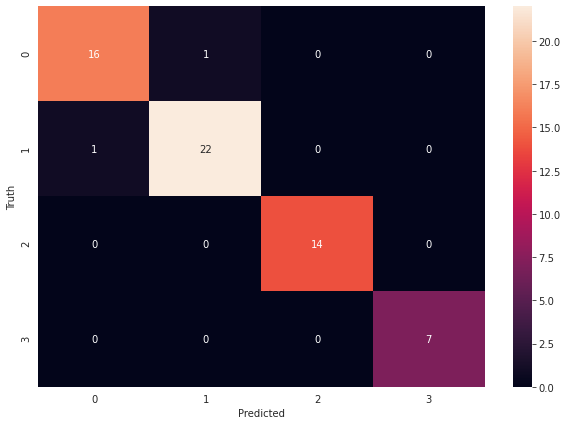

In [99]:
# visualizing the confusion matrix using Seaborn library in python
import seaborn as sn
plt.figure(figsize=(10,7))
sn.heatmap(cm, annot=True)
plt.xlabel('Predicted')
plt.ylabel('Truth')

In [100]:
pd.DataFrame(zip(xtrain.columns, np.transpose(model.coef_.tolist()[0])), columns=['features', 'coef'])

,features,coef
0,ID,-0.000430
1,Air temperature [K],0.745393
2,Process temperature [K],-0.112535
3,Rotational speed [rpm],-0.061290
4,Torque [Nm],-0.814523
5,Tool wear [min],-0.175796
6,Temp Diff,-0.857928
7,Power,-0.048882
8,H,-0.169795
9,M,0.304744
